In [37]:
import requests
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
from tqdm import tqdm
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
import cvxpy as cp


gecko_api = "CG-mUTprwD2T4dKrdcAsPFukCU8"
base_url = "https://api.coingecko.com/api/v3/"


In [38]:
def sendRequest(endpoint: str, params: dict[str, str]) -> dict:
    response = requests.get(f"{base_url}{endpoint}", params=params, headers={"Authorization": f"Bearer {gecko_api}"})
    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        return data
    elif response.status_code == 429:
        sleep(30)
        return sendRequest(endpoint, params)
    else:
        raise Exception(f"Request failed with status code {response.status_code} and message {response.text}")

Getting a list of all possible candidates 

In [39]:
fetch = False

In [40]:
if fetch:
    endpoint = "coins/markets"
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 50,
        'page': 1,
        'sparkline': 'false'
    }
    coins = sendRequest(endpoint, params)
    coin_df =  pd.DataFrame(coins)
    stables = ["Tether", "USDC", "Ethena USDe", "USDS", "Dai"]
    coin_df = coin_df[~coin_df["name"].isin(stables)]
    coin_df.sort_values(by="total_volume", ascending=False, inplace=True)
    coin_df.reset_index(drop=True, inplace=True)
    coin_df = coin_df[coin_df.index < 30]
    coin_df.to_csv("coins.csv", index=False)
else:
    coin_df = pd.read_csv("coins.csv")

Getting the data 

In [41]:
day = 24*60*60
delta = day * 89
_range = 5

now = int(dt.datetime.now().timestamp() // 1)

## I initially wanted to get 5 minute data but there is a limit of 30 requests per minute which would case it to take 6 hours to get all the data
## As we need to fetch one day at a time to get that granularity

## You can only get hourly data at a range of 90 days or less so wer have to paginate
##Exception: Request failed with status code 401 and message {"error":{"status":{"timestamp":"2025-01-16T12:17:28.846+00:00","error_code":10012,"error_message":"Your request exceeds the allowed time range. Public API users are limited to querying historical data within the past 365 days. Upgrade to a paid plan to enjoy full historical data access: https://www.coingecko.com/en/api/pricing. "}}}

In [42]:
def coinEndPoint(id: str) -> str:
    return f"coins/{id}/market_chart/range"


if fetch:
    hour_data: dict[str, dict[int: float]] = {}
    day = 24*60*60
    delta = day * 89
    _range = 5
    for id in tqdm(coin_df.id):
        hour_data[id] = {}
        to = now
        _from = to - delta
        endpoint = coinEndPoint(id)
        for i in range(_range):
            params = {
                "vs_currency": "usd",
                "from": _from,
                "to": to,
            }
            data = sendRequest(endpoint, params)
            for d in data["prices"]:
                time = d[0]
                price = d[1]
                hour_data[id][time] = price
            to = _from
            _from = max(to - delta, now - 365 * day) ## Stop errors
    for id, data in hour_data.items():
        hour_data[id] = dict(sorted(data.items(), key=lambda x: x[0]))
    with open("hour_data.json", "w") as f:
        json.dump(hour_data, f, indent=4)
else:
    with open("hour_data.json", "r") as f:
        hour_data = json.load(f)
    for id, data in hour_data.items():
        hour_data[id] = {int(k): v for k, v in data.items()}



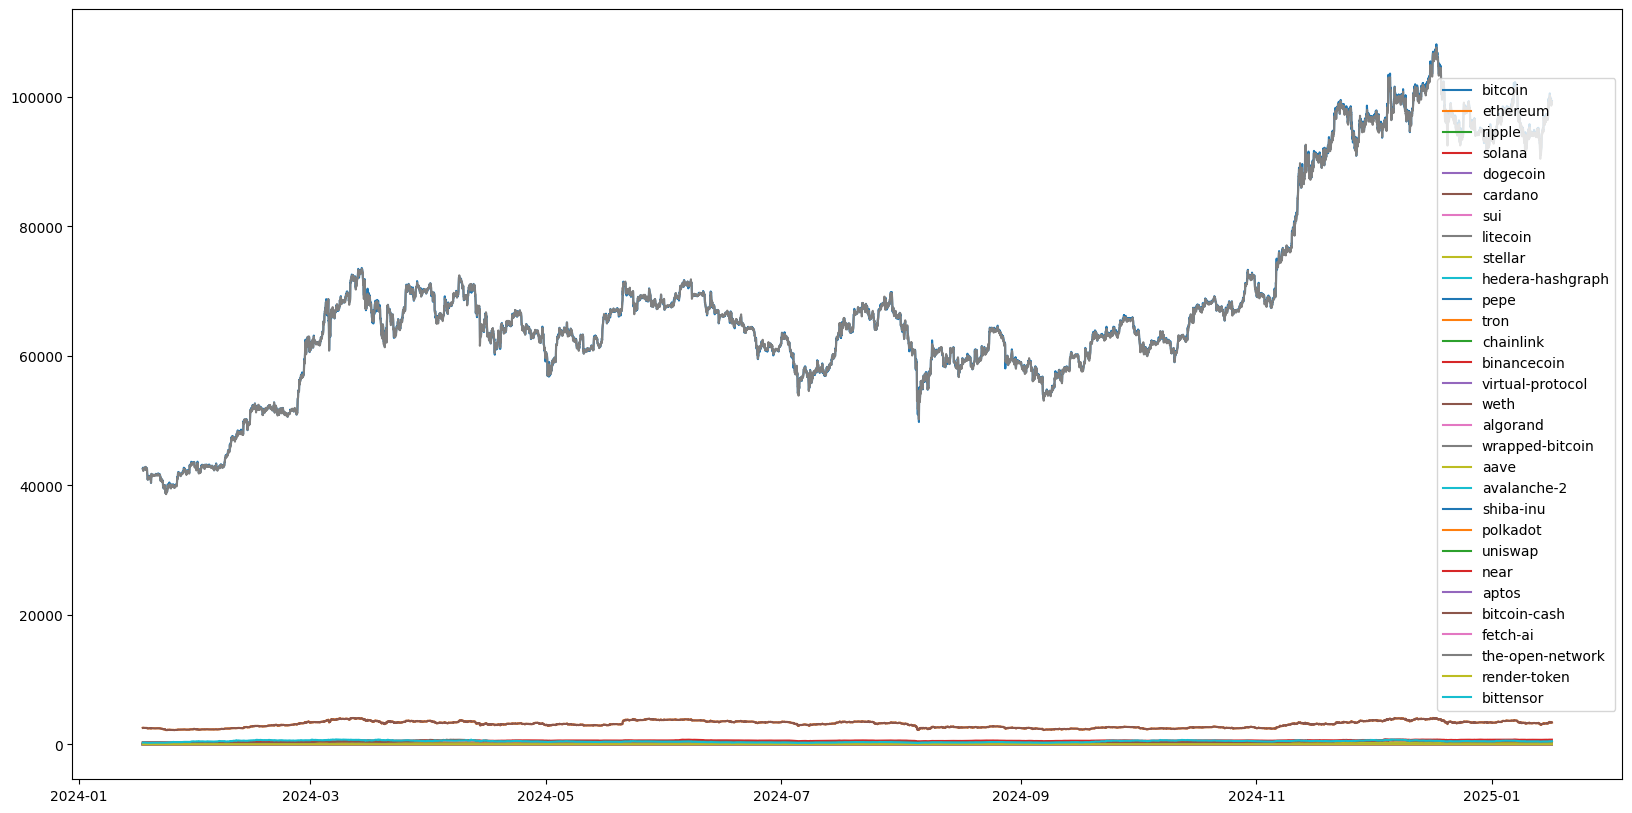

In [43]:
plt.figure(figsize=(20, 10))

for id, data in hour_data.items():
    times = [dt.datetime.fromtimestamp(int(x/1000)) for x in list(data.keys())]
    prices = list(data.values())
    plt.plot(times, prices, label=id)
    
plt.legend()
plt.show()

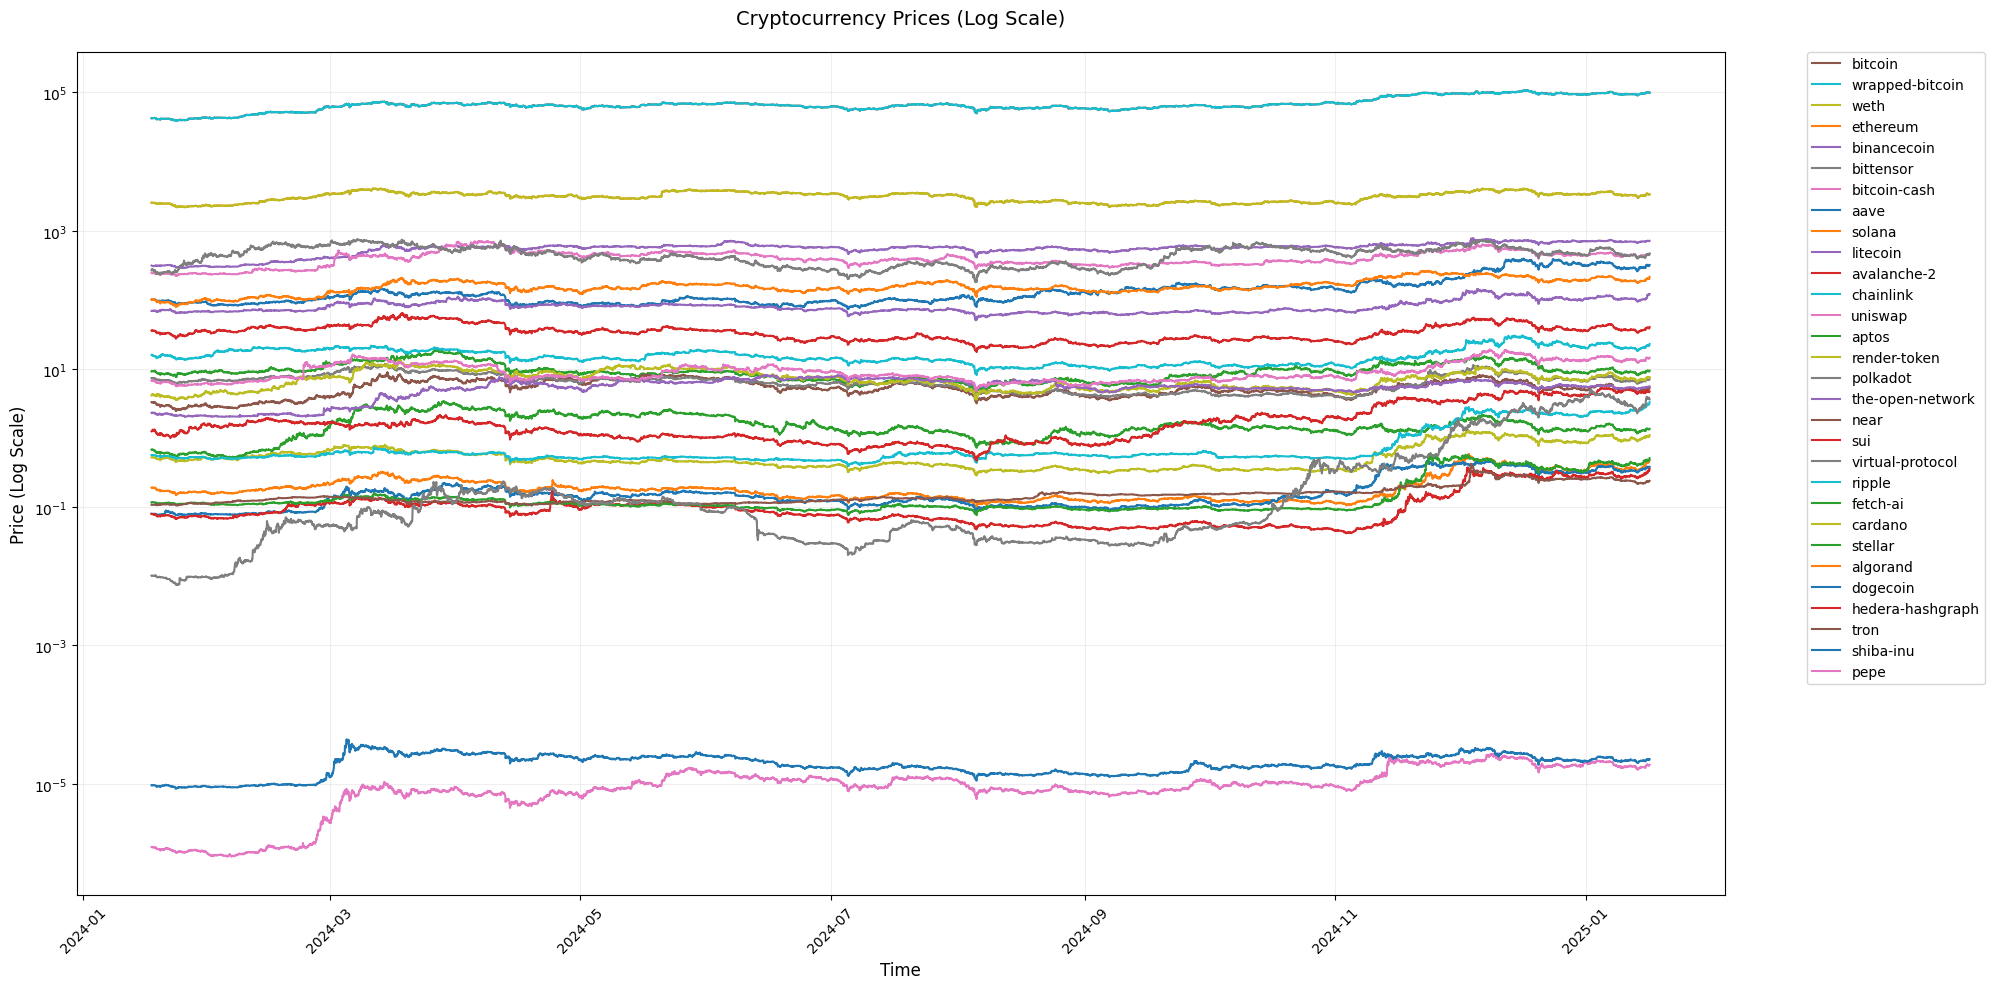

In [44]:
plt.figure(figsize=(20, 10))
plt.yscale('log')

# Dictionary to store final y-values
final_y_values = {}

# Plot and store final values
for id, data in sorted(hour_data.items()):
    times = [dt.datetime.fromtimestamp(int(x/1000)) for x in list(data.keys())]
    prices = list(data.values())
    plt.plot(times, prices, label=id, linewidth=1.5)
    final_y_values[id] = prices[-1]  # Store final y-value

# Sort legend by final y-values (top to bottom)
handles, labels = plt.gca().get_legend_handles_labels()
sorted_pairs = sorted(zip(handles, labels), 
                     key=lambda x: final_y_values[x[1]], 
                     reverse=True)  # reverse=True for top-to-bottom order
handles, labels = zip(*sorted_pairs)

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.title('Cryptocurrency Prices (Log Scale)', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (Log Scale)', fontsize=12)

plt.xticks(rotation=45)
# Create legend with sorted entries
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.)
plt.tight_layout()

plt.show()

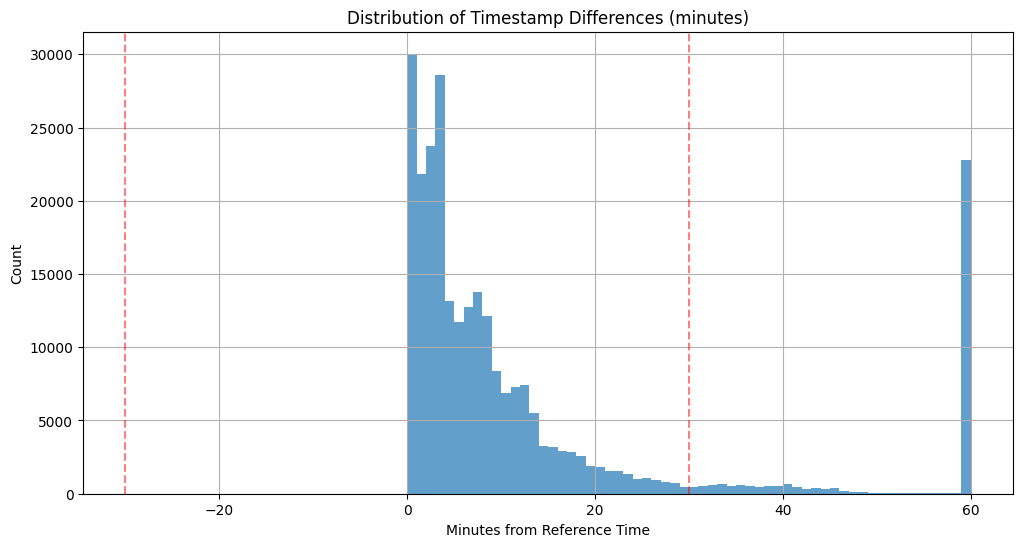

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Get first timestamp as reference
ref_time = min(min(data.keys()) for data in hour_data.values())

ref_time_hour = ref_time/1000/60/60

# Calculate time differences in minutes
time_diffs = []
for crypto, data in hour_data.items():
    timestamps = np.array(list(data.keys()))
    diffs_minutes = ((timestamps - ref_time)/1000/60) % 60  # Convert to minutes
    time_diffs.extend(diffs_minutes)

# Plot distribution
plt.figure(figsize=(12, 6))
plt.hist(time_diffs, bins=60, alpha=0.7)
plt.axvline(30, color='r', linestyle='--', alpha=0.5)
plt.axvline(-30, color='r', linestyle='--', alpha=0.5)
plt.title('Distribution of Timestamp Differences (minutes)')
plt.xlabel('Minutes from Reference Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Based on this we should move the ref time back by 1 minute

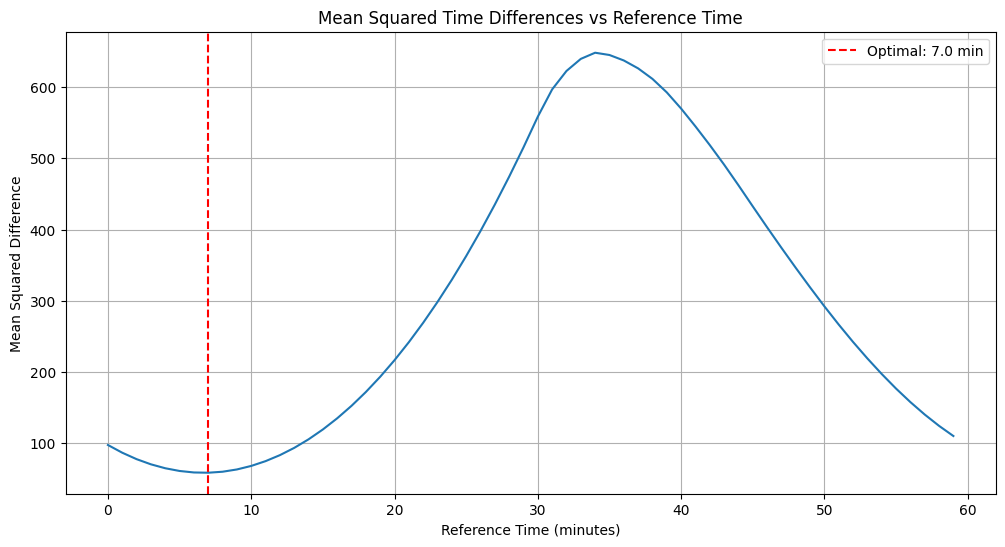

Optimal reference time: 7.0 minutes


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Get all timestamps
all_times = []
for crypto, data in hour_data.items():
    timestamps = np.array(list(data.keys()))
    minutes = (timestamps/1000/60) % 60  # Convert to minutes
    all_times.extend(minutes)

# Calculate optimal reference time
ref_times = np.arange(0, 60, 1)  # Test all minutes
squared_diffs = []

for ref in ref_times:
    diffs = np.minimum(np.abs(np.array(all_times) - ref), 
                      60 - np.abs(np.array(all_times) - ref))
    squared_diff = np.mean(diffs ** 2)
    squared_diffs.append(squared_diff)

# Find optimal reference time
optimal_ref = ref_times[np.argmin(squared_diffs)]

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(ref_times, squared_diffs)
plt.axvline(optimal_ref, color='r', linestyle='--', label=f'Optimal: {optimal_ref:.1f} min')
plt.title('Mean Squared Time Differences vs Reference Time')
plt.xlabel('Reference Time (minutes)')
plt.ylabel('Mean Squared Difference')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal reference time: {optimal_ref:.1f} minutes")

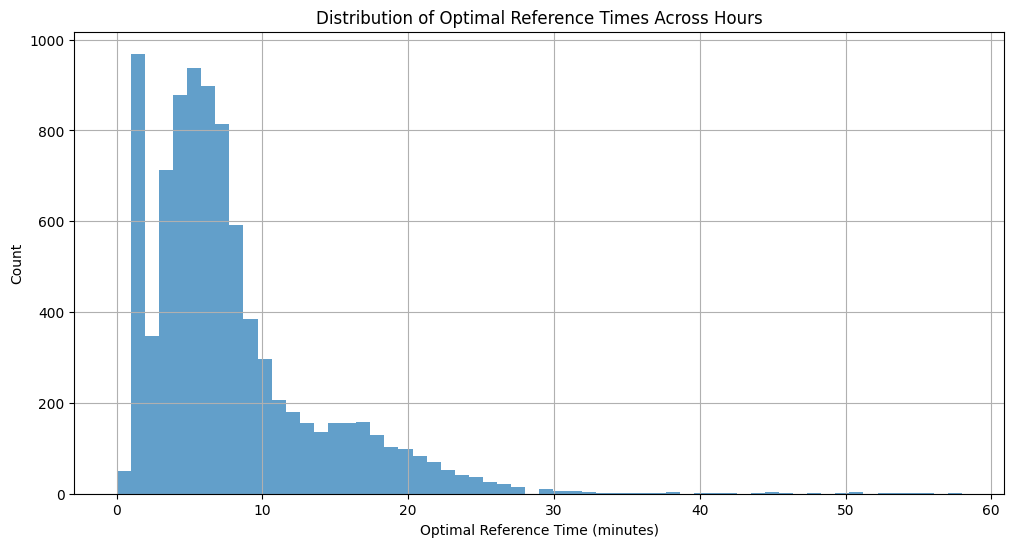

Mean optimal reference time: 7.6 minutes
Std of optimal reference times: 6.2 minutes


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Group timestamps by hour
hour_groups = defaultdict(list)
for crypto, data in hour_data.items():
    for timestamp in data.keys():
        hour = (timestamp // (1000 * 60 * 60))  # Get hour bucket
        minute = ((timestamp / 1000 / 60) % 60)  # Get minute within hour
        hour_groups[hour].append(minute)

# Calculate optimal reference for each hour
hour_refs = {}
for hour, minutes in hour_groups.items():
    minutes = np.array(minutes)
    ref_times = np.arange(0, 60, 1)
    min_diff = float('inf')
    optimal_ref_individual = 0
    
    for ref in ref_times:
        diffs = np.minimum(np.abs(minutes - ref), 60 - np.abs(minutes - ref))
        squared_diff = np.mean(diffs ** 2)
        if squared_diff < min_diff:
            min_diff = squared_diff
            optimal_ref_individual = ref
    
    hour_refs[hour] = optimal_ref_individual

# Plot distribution of optimal reference times
plt.figure(figsize=(12, 6))
plt.hist(list(hour_refs.values()), bins=60, alpha=0.7)
plt.title('Distribution of Optimal Reference Times Across Hours')
plt.xlabel('Optimal Reference Time (minutes)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Mean optimal reference time: {np.mean(list(hour_refs.values())):.1f} minutes")
print(f"Std of optimal reference times: {np.std(list(hour_refs.values())):.1f} minutes")

After trying to do this and allocate the optimal time slot to each I realized that the data was not the same length and I was going to have to try and impute values

In [48]:

ref_time = min(min(data.keys()) for data in hour_data.values())
ref_time = int(ref_time - 60 * 1000 * optimal_ref)
minute_part = ref_time % (60 * 1000)

In [49]:
hour_milliseconds = 60 * 60 * 1000

max_ref_time = max(max(data.keys()) for data in hour_data.values())
max_ref_time_hour = int(max_ref_time // hour_milliseconds)

max_ref_time = max_ref_time_hour * hour_milliseconds + minute_part

new_values = {}

for ticker, prices in hour_data.items():
    updated_data = prices.copy()
    all_times = np.array(sorted(prices.keys()))
    for hour in range(ref_time, max_ref_time + hour_milliseconds, hour_milliseconds):
        if len(all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]) == 0:
            updated_data[hour] = np.nan
    new_values[ticker] = updated_data
    


In [50]:
print(min(len(data) for data in new_values.values()))
print(max(len(data) for data in new_values.values()))


8765
8775


In [51]:
##This is actually much worse lol
print([len(data) for data in hour_data.values()])

[8755, 8756, 8755, 8755, 8756, 8755, 8753, 8757, 8756, 8755, 8755, 8755, 8753, 8753, 8754, 8753, 8754, 8753, 8754, 8755, 8756, 8754, 8754, 8755, 8756, 8754, 8753, 8757, 8756, 8755]


In [52]:
new_values_again = {}

for ticker, prices in hour_data.items():
    updated_data = {} 
    all_times = np.array(sorted(prices.keys()))
    _prev = np.nan
    for hour in range(ref_time, max_ref_time + hour_milliseconds, hour_milliseconds):
        if len(all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]) == 0:
            updated_data[hour] = _prev
        elif len(all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]) == 1:
            updated_data[hour] = prices[all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)][0]]
            _prev = np.nan
        elif len(all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]) == 2:
            lower, upper = all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]
            if hour - hour_milliseconds not in updated_data or np.isnan(updated_data.get(hour - hour_milliseconds, np.nan)):
                updated_data[hour - hour_milliseconds] = prices[lower]
                updated_data[hour] = prices[upper]
                _prev = np.nan
            else:
                updated_data[hour] = prices[lower]
                _prev = prices[upper]
        elif len(all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]) == 3:
            lower, middle, upper = all_times[(all_times > hour) & (all_times < hour + hour_milliseconds)]
            if hour - hour_milliseconds not in updated_data or np.isnan(updated_data.get(hour - hour_milliseconds, np.nan)):
                updated_data[hour - hour_milliseconds] = prices[lower]
                updated_data[hour] = prices[middle]
                _prev = prices[upper]
            else:
                updated_data[hour] = prices[lower]
                _prev = prices[middle]
        else:
            raise Exception("Too many values")
            
    new_values_again[ticker] = updated_data

In [53]:
print(min(len(data) for data in new_values_again.values()))
print(max(len(data) for data in new_values_again.values()))

8761
8761


In [54]:
data_df = pd.DataFrame({ticker: list(data.values()) for ticker, data in new_values_again.items()})

In [55]:
data_df.index = [dt.datetime.fromtimestamp(x/1000) for x in list(new_values_again.values())[0].keys()]
##All the last values are NaN
data_df = data_df[:-1]

In [56]:
data_df.to_csv("hour_data_imputed.csv", index=False)

In [57]:
##Assuming weth eth are the same price and the same with btc (although OBV Bitcoin is more volatile with Justin Sun etc)
data_df.isna().sum()


bitcoin              7
ethereum             6
ripple               7
solana               7
dogecoin             6
cardano              8
sui                  9
litecoin             5
stellar              6
hedera-hashgraph     7
pepe                 7
tron                 7
chainlink           12
binancecoin         10
virtual-protocol    10
weth                11
algorand             9
wrapped-bitcoin     11
aave                 8
avalanche-2          8
shiba-inu            6
polkadot             8
uniswap             10
near                 7
aptos                7
bitcoin-cash        12
fetch-ai             9
the-open-network     5
render-token         6
bittensor            7
dtype: int64

In [58]:
data_df.drop(columns=["wrapped-bitcoin" , "weth"], inplace=True)

In [59]:
data_df = data_df.copy()
data_df.dropna(inplace=True)

In [60]:
data_df

,bitcoin,ethereum,ripple,solana,dogecoin,cardano,sui,litecoin,stellar,hedera-hashgraph,...,shiba-inu,polkadot,uniswap,near,aptos,bitcoin-cash,fetch-ai,the-open-network,render-token,bittensor
2024-01-17 13:53:43.091,42582.502692,2543.482701,0.568752,101.143357,0.080407,0.528988,1.252851,69.149190,0.117672,0.080342,...,0.000010,7.401312,6.798788,3.316860,9.267436,244.515551,0.683247,2.326234,4.143150,267.392613
2024-01-17 14:53:43.091,42724.221892,2558.570374,0.569265,101.921002,0.080490,0.530446,1.266821,69.091463,0.118031,0.080320,...,0.000010,7.413402,6.813908,3.331456,9.311834,243.573098,0.685002,2.341468,4.249908,270.678715
2024-01-17 15:53:43.091,42467.341569,2536.777074,0.568099,99.534697,0.080077,0.525103,1.263202,68.656170,0.117369,0.079334,...,0.000009,7.329981,6.732682,3.318068,9.218587,241.986374,0.680762,2.325494,4.167319,277.102877
2024-01-17 16:53:43.091,42307.790169,2531.965608,0.567121,98.785475,0.080032,0.525960,1.266518,68.849443,0.117423,0.079391,...,0.000009,7.340573,6.806880,3.287147,9.280952,243.065042,0.682062,2.294678,4.243131,274.404777
2024-01-17 17:53:43.091,42374.461622,2531.888599,0.566434,99.069451,0.080089,0.527571,1.291909,69.141592,0.118456,0.079384,...,0.000009,7.322464,6.805223,3.297591,9.310275,243.702552,0.675296,2.292554,4.275951,276.009653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16 08:53:43.091,98969.278515,3321.058465,3.085477,200.018958,0.370808,1.036400,4.611153,118.336358,0.475565,0.333660,...,0.000022,6.894282,14.100830,5.129107,9.174160,453.876358,1.325796,5.482865,7.327307,444.805066
2025-01-16 09:53:43.091,99119.305447,3332.562513,3.075277,201.097613,0.373853,1.043738,4.615045,117.853059,0.473538,0.333878,...,0.000022,6.921174,14.126715,5.142781,9.181965,454.749806,1.328201,5.489055,7.356374,446.594540
2025-01-16 10:53:43.091,99175.812764,3333.302464,3.100386,200.379478,0.374505,1.043566,4.615037,118.396063,0.480540,0.339248,...,0.000022,6.941248,14.167737,5.150971,9.187320,455.735817,1.329921,5.517211,7.351931,445.979934
2025-01-16 11:53:43.091,99136.885554,3349.945478,3.194155,211.810412,0.377704,1.063422,4.662280,118.468586,0.489432,0.346021,...,0.000022,7.065932,14.279204,5.208439,9.297520,456.432182,1.337078,5.534741,7.494679,455.095334


In [61]:
move_df = (data_df - data_df.shift(1))/ data_df.shift(1)

move_df.dropna(inplace=True)

move_df.to_csv("hour_data_imputed_move.csv", index=False)


In [62]:
## Splitting the data into train and test

In [63]:
df = move_df.copy()

move_df = df[df.index < dt.datetime(2024, 12, 1)]
test_df = df[df.index >= dt.datetime(2024, 12, 1)]

In [64]:
move_df

,bitcoin,ethereum,ripple,solana,dogecoin,cardano,sui,litecoin,stellar,hedera-hashgraph,...,shiba-inu,polkadot,uniswap,near,aptos,bitcoin-cash,fetch-ai,the-open-network,render-token,bittensor
2024-01-17 14:53:43.091,0.003328,0.005932,0.000902,0.007689,0.001024,0.002756,0.011150,-0.000835,0.003051,-0.000263,...,0.001831,0.001633,0.002224,0.004401,0.004791,-0.003854,0.002569,0.006549,0.025767,0.012289
2024-01-17 15:53:43.091,-0.006013,-0.008518,-0.002048,-0.023413,-0.005121,-0.010073,-0.002857,-0.006300,-0.005605,-0.012284,...,-0.009677,-0.011253,-0.011921,-0.004019,-0.010014,-0.006514,-0.006190,-0.006822,-0.019433,0.023734
2024-01-17 16:53:43.091,-0.003757,-0.001897,-0.001722,-0.007527,-0.000563,0.001632,0.002625,0.002815,0.000456,0.000717,...,-0.000137,0.001445,0.011021,-0.009319,0.006765,0.004458,0.001910,-0.013252,0.018192,-0.009737
2024-01-17 17:53:43.091,0.001576,-0.000030,-0.001211,0.002875,0.000707,0.003063,0.020048,0.004243,0.008800,-0.000085,...,0.002867,-0.002467,-0.000243,0.003177,0.003159,0.002623,-0.009920,-0.000926,0.007735,0.005849
2024-01-17 18:53:43.091,0.004126,-0.000488,0.004973,0.010444,0.003681,0.000891,0.008389,0.001669,0.000362,0.002724,...,0.003346,0.001720,0.002643,0.004669,0.002654,-0.003594,0.008025,0.003037,0.010427,-0.002729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 19:53:43.091,0.000383,0.005854,-0.004060,0.001575,0.003756,-0.000136,0.001397,-0.001525,-0.011003,0.009140,...,-0.001645,0.011914,0.008237,-0.005657,-0.004382,-0.004412,-0.003813,0.000979,0.016836,0.005166
2024-11-30 20:53:43.091,-0.000446,0.005549,0.005875,0.003306,0.004101,0.004311,0.002544,-0.002546,0.000173,-0.003840,...,0.003438,-0.000140,0.004986,-0.001872,-0.000666,-0.007632,0.000965,0.003927,-0.003169,0.004177
2024-11-30 21:53:43.091,-0.001808,-0.000448,0.018815,-0.004328,-0.003135,0.003118,0.001620,0.010324,0.007483,0.005333,...,0.004277,-0.000407,0.000151,-0.005924,0.000014,0.000157,-0.000390,0.000992,-0.002571,-0.001967
2024-11-30 22:53:43.091,-0.004753,-0.001657,-0.011845,-0.003170,-0.009353,-0.017024,-0.014138,-0.013018,-0.008749,-0.006618,...,-0.007293,-0.009787,-0.010390,-0.010219,-0.004343,-0.005489,0.003591,-0.005570,-0.014373,0.010869


In [65]:
data_for_fa = move_df.copy()

# data_normalized = move_df.copy()


Initially I tried it without normalizing the data but I was gettings around 99.2 % explained variance with 1 component which seems very wrong

In [ ]:
scaler = StandardScaler()

data_normalized = scaler.fit_transform(data_for_fa)

In [66]:
# Initialize the FactorAnalysis model
fa = FactorAnalysis()  # Adjust the number of components as needed

# Fit the model
fa.fit(data_normalized)

# Get the factor loadings
loadings = fa.components_.T

# Calculate the variance explained by each factor
variance_explained = (loadings ** 2).sum(axis=0) / (loadings ** 2).sum()

# Print the variance explained by each factor
for i, var in enumerate(variance_explained):
    print(f"Factor {i+1} explains {var:.2%} of the variance")

Factor 1 explains 89.83% of the variance
Factor 2 explains 3.71% of the variance
Factor 3 explains 2.71% of the variance
Factor 4 explains 1.50% of the variance
Factor 5 explains 0.93% of the variance
Factor 6 explains 0.64% of the variance
Factor 7 explains 0.31% of the variance
Factor 8 explains 0.20% of the variance
Factor 9 explains 0.12% of the variance
Factor 10 explains 0.06% of the variance
Factor 11 explains 0.00% of the variance
Factor 12 explains 0.00% of the variance
Factor 13 explains 0.00% of the variance
Factor 14 explains 0.00% of the variance
Factor 15 explains 0.00% of the variance
Factor 16 explains 0.00% of the variance
Factor 17 explains 0.00% of the variance
Factor 18 explains 0.00% of the variance
Factor 19 explains 0.00% of the variance
Factor 20 explains 0.00% of the variance
Factor 21 explains 0.00% of the variance
Factor 22 explains 0.00% of the variance
Factor 23 explains 0.00% of the variance
Factor 24 explains 0.00% of the variance
Factor 25 explains 0.00%

### I am going to keep the first 7 which may be overkill, but it gets 3sd of the data

In [67]:
fa_chosen = FactorAnalysis(n_components=7)

In [68]:
# Fit the model
factor_scores = fa_chosen.fit_transform(data_normalized)

# Get the factor loadings
loadings = fa_chosen.components_.T

In [69]:
factor_scores.shape

(7608, 7)

In [70]:
loadings.shape

(28, 7)

In [71]:
def plot_factors_vs_inputs(inputs, factors, input_names=None, save_path=None):
    """
    Plot each input against each factor with correlations
    
    Args:
        inputs: array-like, shape (n_samples, n_features)
        factors: array-like, shape (n_samples, n_factors)
        input_names: list of str, names of input features
        save_path: str, path to save plot
    """
    n_inputs = inputs.shape[1]
    n_factors = factors.shape[1]
    
    # Create subplot grid
    fig, axes = plt.subplots(n_inputs, n_factors, 
                            figsize=(4*n_factors, 3*n_inputs))
    if n_inputs == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each combination
    for i in range(n_inputs):
        for j in range(n_factors):
            ax = axes[i,j]
            
            # Get data
            x = factors[:,j]
            y = inputs[:,i]
            
            # Calculate correlation
            corr = np.corrcoef(x, y)[0,1]
            
            # Create scatter plot
            ax.scatter(x, y, alpha=0.5, s=1)
            ax.set_title(f'{input_names[i]}\nvs Factor {j+1}\nρ={corr:.2f}')
            
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig

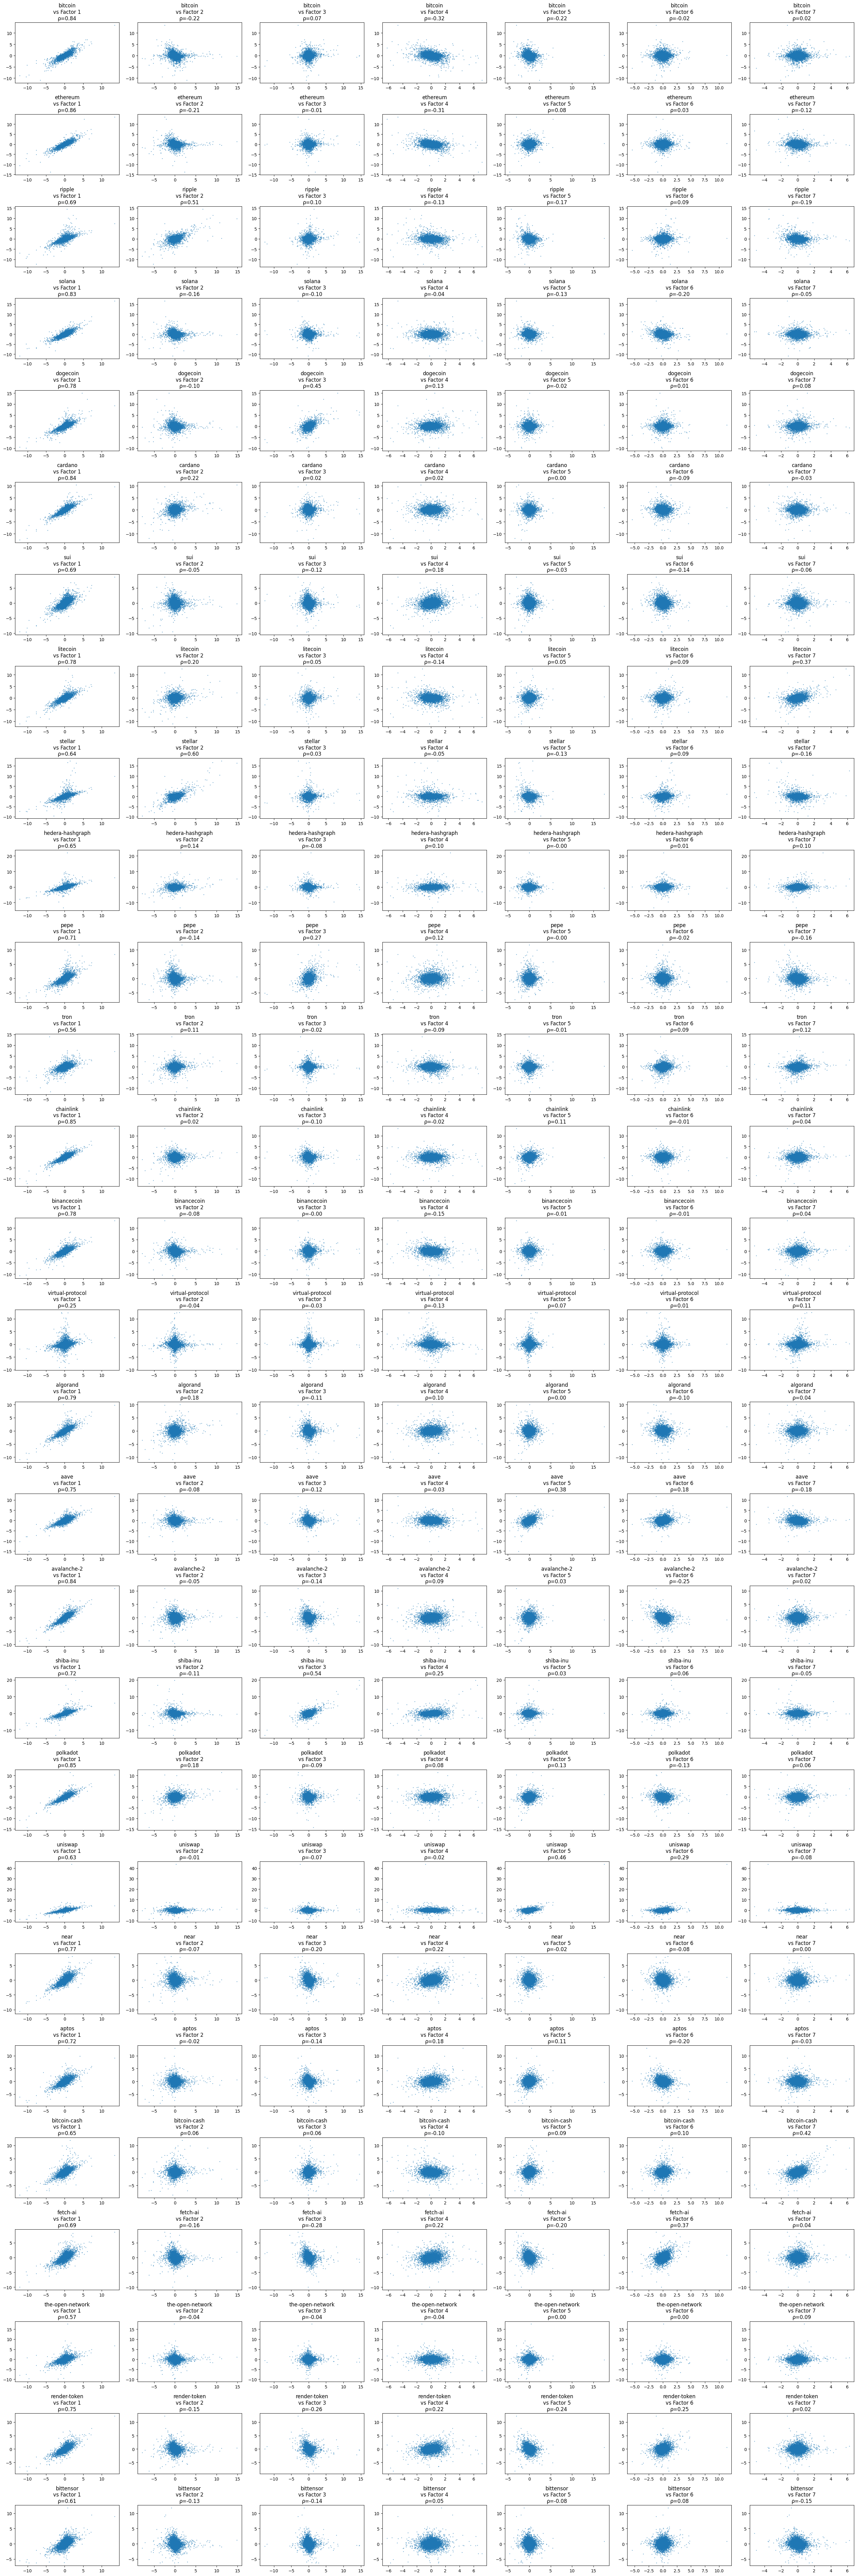

In [72]:
fig = plot_factors_vs_inputs(data_normalized, factor_scores, data_for_fa.columns, save_path="factor_analysis.png")
plt.show()

In [73]:
data_for_fa

,bitcoin,ethereum,ripple,solana,dogecoin,cardano,sui,litecoin,stellar,hedera-hashgraph,...,shiba-inu,polkadot,uniswap,near,aptos,bitcoin-cash,fetch-ai,the-open-network,render-token,bittensor
2024-01-17 14:53:43.091,0.003328,0.005932,0.000902,0.007689,0.001024,0.002756,0.011150,-0.000835,0.003051,-0.000263,...,0.001831,0.001633,0.002224,0.004401,0.004791,-0.003854,0.002569,0.006549,0.025767,0.012289
2024-01-17 15:53:43.091,-0.006013,-0.008518,-0.002048,-0.023413,-0.005121,-0.010073,-0.002857,-0.006300,-0.005605,-0.012284,...,-0.009677,-0.011253,-0.011921,-0.004019,-0.010014,-0.006514,-0.006190,-0.006822,-0.019433,0.023734
2024-01-17 16:53:43.091,-0.003757,-0.001897,-0.001722,-0.007527,-0.000563,0.001632,0.002625,0.002815,0.000456,0.000717,...,-0.000137,0.001445,0.011021,-0.009319,0.006765,0.004458,0.001910,-0.013252,0.018192,-0.009737
2024-01-17 17:53:43.091,0.001576,-0.000030,-0.001211,0.002875,0.000707,0.003063,0.020048,0.004243,0.008800,-0.000085,...,0.002867,-0.002467,-0.000243,0.003177,0.003159,0.002623,-0.009920,-0.000926,0.007735,0.005849
2024-01-17 18:53:43.091,0.004126,-0.000488,0.004973,0.010444,0.003681,0.000891,0.008389,0.001669,0.000362,0.002724,...,0.003346,0.001720,0.002643,0.004669,0.002654,-0.003594,0.008025,0.003037,0.010427,-0.002729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 19:53:43.091,0.000383,0.005854,-0.004060,0.001575,0.003756,-0.000136,0.001397,-0.001525,-0.011003,0.009140,...,-0.001645,0.011914,0.008237,-0.005657,-0.004382,-0.004412,-0.003813,0.000979,0.016836,0.005166
2024-11-30 20:53:43.091,-0.000446,0.005549,0.005875,0.003306,0.004101,0.004311,0.002544,-0.002546,0.000173,-0.003840,...,0.003438,-0.000140,0.004986,-0.001872,-0.000666,-0.007632,0.000965,0.003927,-0.003169,0.004177
2024-11-30 21:53:43.091,-0.001808,-0.000448,0.018815,-0.004328,-0.003135,0.003118,0.001620,0.010324,0.007483,0.005333,...,0.004277,-0.000407,0.000151,-0.005924,0.000014,0.000157,-0.000390,0.000992,-0.002571,-0.001967
2024-11-30 22:53:43.091,-0.004753,-0.001657,-0.011845,-0.003170,-0.009353,-0.017024,-0.014138,-0.013018,-0.008749,-0.006618,...,-0.007293,-0.009787,-0.010390,-0.010219,-0.004343,-0.005489,0.003591,-0.005570,-0.014373,0.010869


In [74]:
factor_score_df = pd.DataFrame(factor_scores, index=data_for_fa.index)
loading_df = pd.DataFrame(loadings, index=data_for_fa.columns, columns=[f"Factor {i+1}" for i in range(loadings.shape[1])])

In [75]:
factor_score_df

,0,1,2,3,4,5,6
2024-01-17 14:53:43.091,0.590702,-0.659677,-0.896919,0.194625,-0.431772,0.061977,-0.588812
2024-01-17 15:53:43.091,-1.131713,0.275026,0.307760,0.218561,0.085721,0.635526,-0.153634
2024-01-17 16:53:43.091,-0.201056,0.356300,-0.098967,0.754998,0.283791,1.030449,0.303916
2024-01-17 17:53:43.091,0.180490,0.234219,-0.013645,0.153191,-0.250152,-0.318325,-0.116964
2024-01-17 18:53:43.091,0.410724,-0.204839,-0.256061,0.359890,-0.790614,-0.186293,-0.065973
...,...,...,...,...,...,...,...
2024-11-30 19:53:43.091,0.514135,-0.395364,-0.939028,0.362138,0.886233,-0.306163,0.253060
2024-11-30 20:53:43.091,0.096488,-0.550996,0.513083,-0.759092,0.421030,0.384154,-1.002888
2024-11-30 21:53:43.091,0.017530,1.716773,0.614884,-0.371422,-0.338971,0.724247,-0.256303
2024-11-30 22:53:43.091,-0.960741,-1.301206,-0.312795,-0.003472,0.217934,0.187301,-0.667092


Its clear that the first factor is somewhat of a market barometer (all positive and by far the most significant), we'll call it the market factor

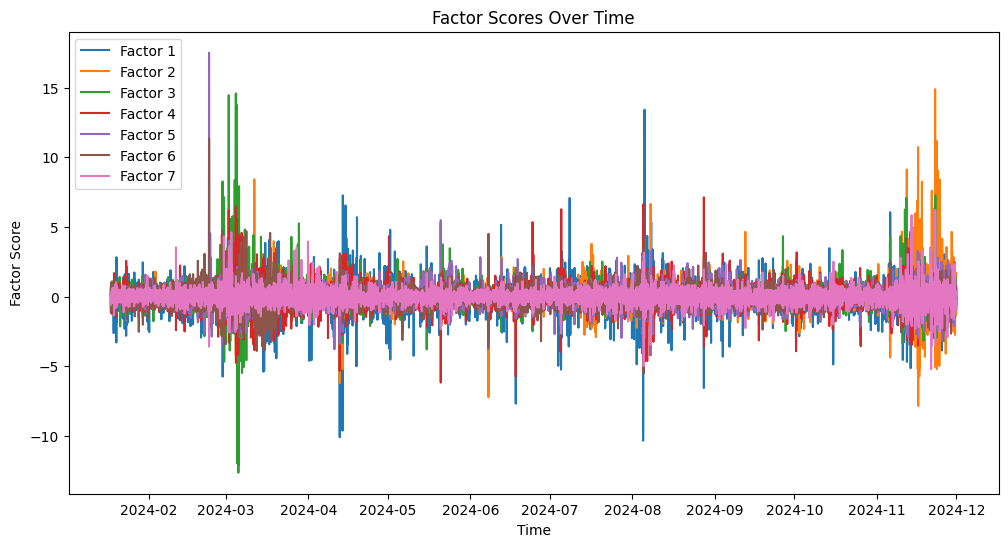

In [76]:
def plot_factor_scores(factor_scores, timestamps, save_path=None):
    """
    Plot the factor scores over time
    
    Args:
        factor_scores: array-like, shape (n_samples, n_factors)
        timestamps: array-like, shape (n_samples,), timestamps corresponding to the factor scores
        save_path: str, path to save plot
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i in range(factor_scores.shape[1]):
        ax.plot(timestamps, factor_scores[:,i], label=f'Factor {i+1}')
        
    ax.set_title('Factor Scores Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Factor Score')
    ax.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig

timestamps = np.array(data_for_fa.index)

# Assuming 'timestamps' is defined and corresponds to the factor scores
fig = plot_factor_scores(factor_scores, timestamps, save_path="factor_scores.png")
plt.show()


In [77]:
#F_t = (B_transpose * B)^-1 * B_transpose * R_t
# This comes from an OLS regression where we are trying to find the factor returns that best explain the returns of the assets
# IE R = B * F + E where R is the returns of the assets, B is the factor loadings, F is the factor returns and E is the residuals
factor_returns = np.dot(np.linalg.inv(np.dot(loadings.T, loadings)), np.dot(loadings.T, data_normalized.T)).T

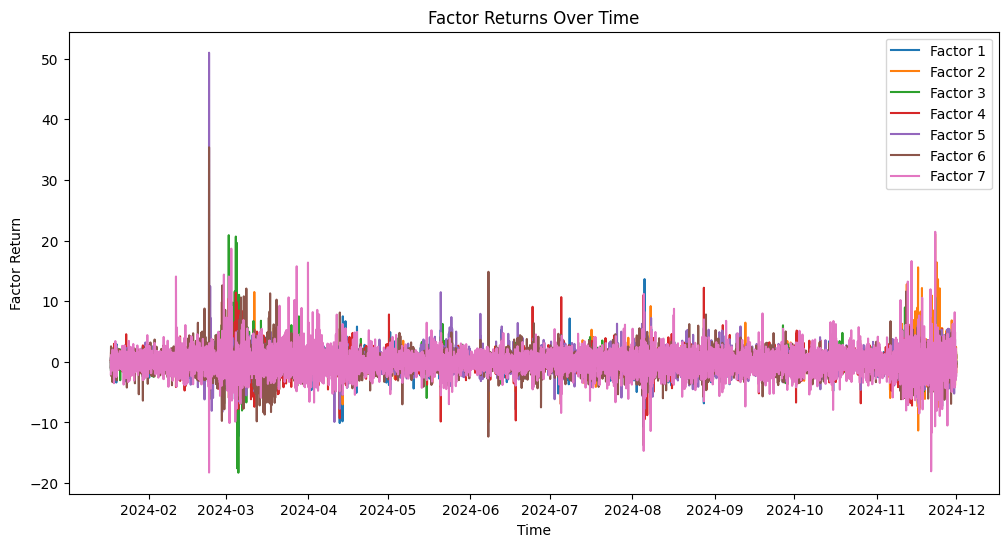

In [78]:
def plot_factor_returns(factor_returns, timestamps, save_path=None):
    """
    Plot the factor returns over time
    
    Args:
        factor_returns: array-like, shape (n_samples, n_factors)
        timestamps: array-like, shape (n_samples,), timestamps corresponding to the factor returns
        save_path: str, path to save plot
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i in range(factor_returns.shape[1]):
        ax.plot(timestamps, factor_returns[:,i], label=f'Factor {i+1}')
        
    ax.set_title('Factor Returns Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Factor Return')
    ax.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    return fig

plot_factor_returns(factor_returns, data_for_fa.index)
plt.show()

In [79]:
from statsmodels.tsa.ar_model import AutoReg

model = [AutoReg(factor_returns[:,j], lags=[i for i in range(1, 10)]) for j in range(factor_returns.shape[1])]

model_fit = [m.fit() for m in model]

for i, m in enumerate(model_fit):
    print(f"Factor {i+1}:")
    print(m.summary())
    

Factor 1:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 7608
Model:                     AutoReg(9)   Log Likelihood              -10867.090
Method:               Conditional MLE   S.D. of innovations              1.011
Date:                Mon, 20 Jan 2025   AIC                          21756.181
Time:                        20:53:24   BIC                          21832.474
Sample:                             9   HQIC                         21782.362
                                 7608                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.154e-05      0.012      0.006      0.995      -0.023       0.023
y.L1           0.0280      0.011      2.444      0.015       0.006       0.051
y.L2          -0.0264      0.011     -2.30

From this we can see that factors 1-3 are positively autocreated and factor 6 is negatively correlated (all above 3sd)

Using this data I am going to construct multiple portfolios that we can use to trade, taking each combination of the factors \
Thus there will be

In [80]:
def construct_factor_portfolio(B, F, Phi, desired_f):
    """
    Construct a single portfolio based on time-series factor returns and autoregressive predictions.

    Parameters:
        B (numpy.ndarray): Factor loadings matrix (n_assets x n_factors).
        F (numpy.ndarray): Factor return matrix (n_factors x n_datapoints).
        Phi (numpy.ndarray): Autoregression coefficients (n_factors x n_factors).
        desired_f (numpy.ndarray): Desired factor exposures (n_factors x 1).

    Returns:
        numpy.ndarray: Optimal portfolio weights (n_assets x 1).
    """
    # Ensure inputs are numpy arrays
    B = np.array(B)
    F = np.array(F)
    Phi = np.array(Phi)
    desired_f = np.array(desired_f)

    # Check dimensions
    n_assets, n_factors = B.shape
    n_factors_F, n_timestamps = F.shape
    if n_factors_F != n_factors:
        raise ValueError("Number of factors in F must match number of columns in B.")
    if len(desired_f) != n_factors:
        raise ValueError("Length of desired_f must match number of factors.")
    if Phi.shape != (n_factors, n_factors):
        raise ValueError("Phi must have shape (n_factors, n_factors).")

    # Predict factor returns for all time steps (F_next = Phi @ F_t)
    F_next = np.zeros_like(F)
    for t in range(1, F.shape[1]):  # Start from 1 since t-1 is needed
        F_next[:, t] = Phi @ F[:, t - 1]

    # Predict asset returns for all time steps
    R_next = B @ F_next  # Predicted asset returns matrix (n_assets x n_timestamps)

    # Define the decision variable (portfolio weights)
    w = cp.Variable(n_assets)

    # Objective: Minimize residual risk across all time steps
    residuals = R_next - w[:, None]  # Residuals for each time step
    objective = cp.Minimize(cp.norm(residuals, "fro"))  # Frobenius norm across all residuals

    # Constraints: Achieve desired factor exposures
    constraints = [B.T @ w == desired_f]

    # Solve the optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    # Check solver status
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Solver failed with status: {problem.status}")
    
    return w.value




In [81]:
def psi(model_fit, n_factors):
    """
    Calculate the autoregression coefficients for each factor (AR(1)).
    
    Parameters:
        model_fit (list): List of fitted AutoReg models (AR(1)).
        n_factors (int): Number of factors.
    
    Returns:
        numpy.ndarray: Autoregression coefficients matrix (n_factors x n_factors).
    """
    # Initialize matrix to store coefficients
    Phi = np.zeros((n_factors, n_factors))
    
    # Populate the diagonal of Phi with AR(1) coefficients for each factor
    for i, m in enumerate(model_fit):
        Phi[i, i] = m.params[1]  # AR(1) coefficient (skip intercept)
    
    return Phi

# Fit AR(1) models for each factor
model = [AutoReg(factor_returns[:, j], lags=1) for j in range(factor_returns.shape[1])]
model_fit = [m.fit() for m in model]

# Get the Phi matrix
n_factors = factor_returns.shape[1]  # Number of factors
Phi = psi(model_fit, n_factors)

# Print the Phi matrix
print("Autoregression Coefficients (Phi):")
print(Phi)

Autoregression Coefficients (Phi):
[[ 0.02735241  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.02005956  0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.03869458  0.          0.          0.
   0.        ]
 [ 0.          0.          0.         -0.01024206  0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.01430618  0.
   0.        ]
 [ 0.          0.          0.          0.          0.         -0.02936408
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -0.02914664]]


In [82]:
## We can verify and check that these match (not perfectly) the AR(1) coefficients from the summary of the model above
## If I were to make a more advanced model I would could check cross correlations of factors IE t vs t+1 across all factors
## Here we just end up with a diagonal matrix which is simpler

In [83]:
shapes: dict[str, tuple] = {
    "one":   [1, 0, 0, 0, 0, 0, 0],
    "two":   [0, 1, 0, 0, 0, 0, 0],
    "three": [0, 0, 1, 0, 0, 0, 0],
    "six":  [0, 0, 0, 0, 0, -1, 0],
    "oneTwo": [1, 1, 0, 0, 0, 0, 0],
    "oneThree": [1, 0, 1, 0, 0, 0, 0],
    "twoThree": [0, 1, 1, 0, 0, 0, 0],
    "oneSix": [1, 0, 0, 0, 0, -1, 0],
    "twoSix": [0, 1, 0, 0, 0, -1, 0],
    "threeSix": [0, 0, 1, 0, 0, -1, 0],
    "oneTwoThree": [1, 1, 1, 0, 0, 0, 0],
    "oneTwoSix": [1, 1, 0, 0, 0, -1, 0],
    "oneThreeSix": [1, 0, 1, 0, 0, -1, 0],
    "twoThreeSix": [0, 1, 1, 0, 0, -1, 0],
    "oneTwoThreeSix": [1, 1, 1, 0, 0, -1, 0],
}

In [84]:
all_portfolios = {
    name: construct_factor_portfolio(loadings, factor_returns.T, Phi, np.array(shapes[name]))
    for name in shapes
}

In [85]:
## I actually have no testing data now. I forgot to do the train test split

In [86]:
construct_factor_portfolio(loadings, factor_returns.T, Phi, [1, 0, 0, 0, 0, 0, 0])

array([0.08224446, 0.07712669, 0.05185766, 0.06934877, 0.05864824,
       0.05732958, 0.04556012, 0.04637884, 0.04023183, 0.03445184,
       0.05829239, 0.03608122, 0.05486316, 0.06197831, 0.01726031,
       0.04746292, 0.04576695, 0.05792344, 0.0540143 , 0.04996382,
       0.02977535, 0.04456817, 0.04353848, 0.03677278, 0.03176415,
       0.03844093, 0.04095883, 0.0442766 ])

In [87]:
factor_return_data = []

for i in range(factor_returns.shape[1]):
    _i = factor_returns[:, i]
    factor_return_data.append({
        "mean": np.mean(_i),
        "std": np.std(_i),
        "sharpe": np.mean(_i)/np.std(_i),
    })

In [88]:
# All of these means are essentially 0.
# Thus we just need to have a +-sd to know when to buy/short


The strategy is if any of the factor returns are +- 2sd away from 0 we will buy/short the corresponding portfolio \
If there are multiple we will trade the corresponding combination portfolio \
I am using equal weight atm, but it likley makes some sense to use the sharpe ratio as a weight \
Or to weight them by the amount of variance they explain and or the significance level of the autocorrelation

In [100]:
def choose_portfolio(factors_return, bounds):
    """
    Choose the best portfolio based on factor returns and bounds.
    
    Parameters:
        factor_returns (numpy.ndarray): Factor returns matrix (n_datapoints x n_factors).
        bounds (dict): Dictionary of factor bounds (factor_name: bound).
    
    Returns:
        numpy.ndarray: Portfolio weights (n_assets x 1).
    """
    
    # Choose the best factor based on the bounds
    f = np.zeros(len(factors_return))
    for factor, bound in zip(factors_return, bounds.values()):
        if factor > bound:
            f[i] = 1
        elif factor < -bound:
            f[i] = -1
        else:
            f[i] = 0
    if all([x == 0 for x in f]): ##If all factors are within bounds
        return np.zeros(28)
    return construct_factor_portfolio(loadings, factor_returns.T, Phi, f)
        

In [108]:
bounds_1_sd = {f"factor: {i+1}": _data["std"] for i, _data in enumerate(factor_return_data)}
bounds_2_sd = {f"factor: {i+1}": 2 * _data["std"] for i, _data in enumerate(factor_return_data)}

In [109]:
test_df_factor_returns = np.dot(test_df.values, loadings)

In [110]:
test_df_factor_returns_normalized = scaler.fit_transform(test_df_factor_returns)

In [111]:
def estimeate_returns(test_df_factor_returns_normalized, bounds):
    testing_list = [np.array(choose_portfolio(test_df_factor_returns_normalized[i], bounds)) for i in range(test_df_factor_returns_normalized.shape[0])]
    testing_array = np.roll(np.array(testing_list), 1)
    testing_array[0] = np.zeros(28)
    return np.sum(testing_array * test_df.values, axis=1)

In [112]:
returns_i_sd = estimeate_returns(test_df_factor_returns_normalized, bounds_1_sd)
returns_2_sd = estimeate_returns(test_df_factor_returns_normalized, bounds_2_sd)

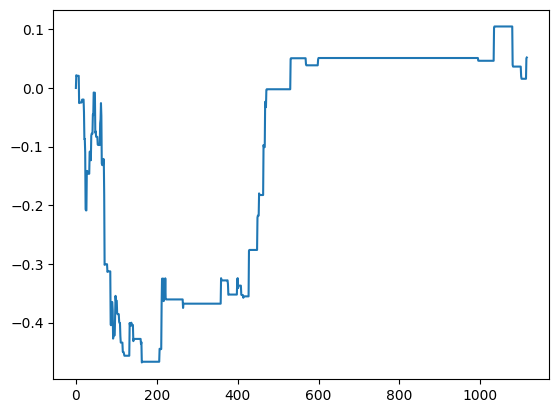

In [113]:
plt.plot(returns_i_sd.cumsum())

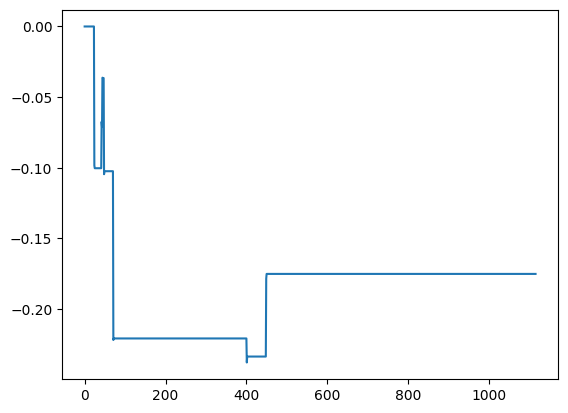

In [114]:
plt.plot(returns_2_sd.cumsum())